# Проект: Прогнозирование заказов такси


**Описание исседования** <br>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Описание данных**

Количество заказов находится в столбце 'num_orders'

**Содержание**

 [Шаг 1. Загрузка данных и ресемплирование](#step1)
 
 [Шаг 2. Анализ данных](#step2)
 
 [Шаг 3. Обучение моделей](#step3)
 
 [Шаг 4. Тестирование](#step4)
 

<a id = 'step1'></a>
# Шаг 1. Загрузка данных и ресемплирование

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6


import warnings
warnings.filterwarnings("ignore")

In [2]:
if os.path.exists('taxi.csv'):
    data = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0]) #локальный путь
else:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) #путь, указанный в проекте

In [3]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data = data.resample('1H').sum()
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

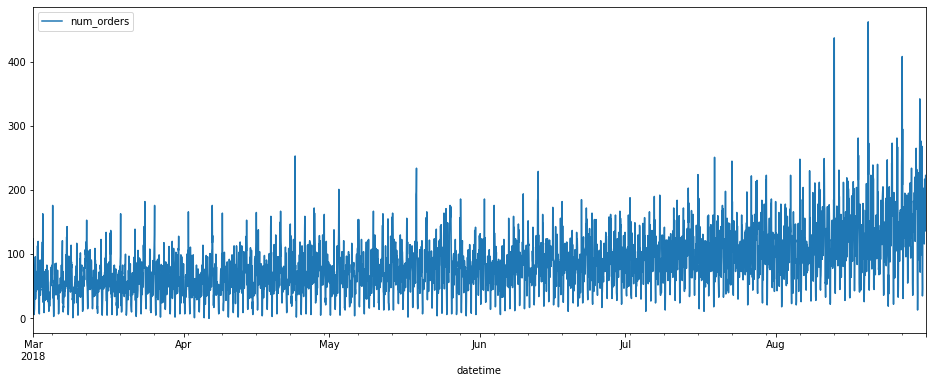

In [7]:
data.plot()
plt.show()

<div class="alert alert-block alert-info">
    
**Выводы** 
    
В файле представлены данные с марта по август (включительно) 2018 года. На данном этапе мы загрузили данные и провели ресемплирование с интервалом в 1 час.

<a id = 'step2'></a>
# Шаг 2. Анализ данных

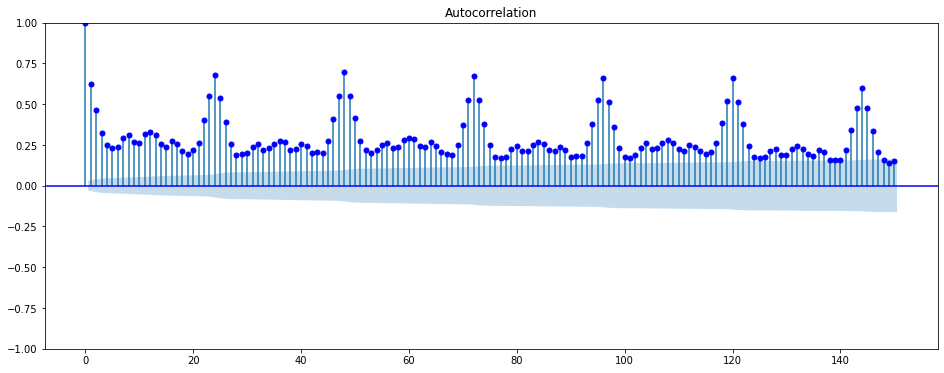

In [8]:
#автокорреляция
plot_acf(data, lags=150, color = 'b')
plt.show()

<div class="alert alert-block alert-info">
<b>Комментарий студента V_2:</b> 
   
На графике присутствуют пики на лагах, кратных ~24-м, значит, в ряде есть сезонность. И, судя по всему, чаще всего такси заказывают ночью 🤔🤔
</div>

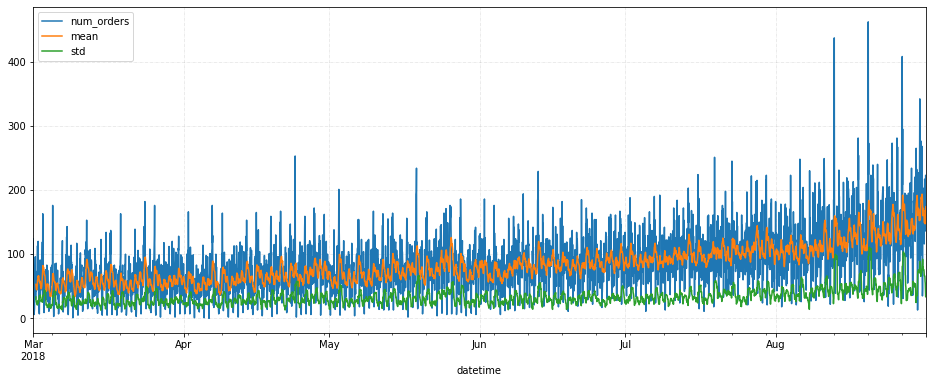

In [9]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot() 
plt.grid(color ='grey',linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

In [10]:
data = data.drop(['mean','std'],axis=1)

In [11]:
#критерий Дики-Фуллера
test = adfuller(data)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
print()
if test[1] < .01:
    print('Отверагем нулевую гипотезу, ряд стационарен')
else:
    print('Не удалось отвергнуть нулевую гипотезу: ряд не стационарен')

adf: -3.0689242890279256
p-value: 0.02894005140261531
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}

Не удалось отвергнуть нулевую гипотезу: ряд не стационарен


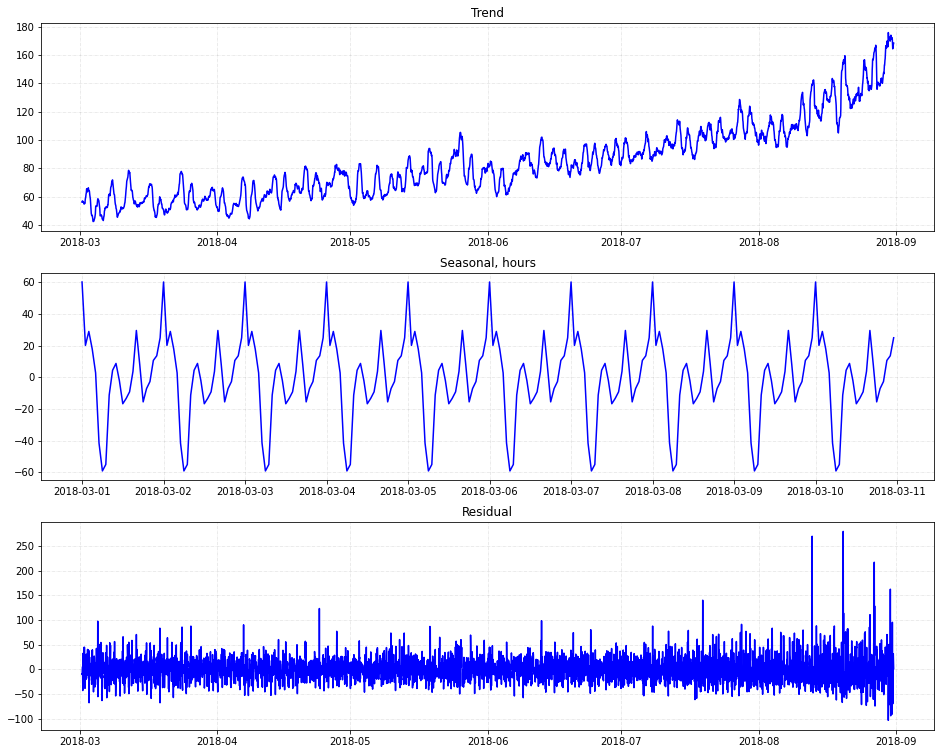

In [12]:
decomposed = seasonal_decompose(data)

fig, axs = plt.subplots(3, figsize=(16,13), sharex=False)
axs[0].plot(decomposed.trend, color = 'b')
axs[0].set_title("Trend")
axs[0].grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.3)

axs[1].plot(decomposed.seasonal['2018-03-01 00:00:00':'2018-03-10 23:00:00'], color = 'b')
axs[1].set_title("Seasonal, hours")
axs[1].grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.3)

axs[2].plot(decomposed.resid, color = 'b')
axs[2].set_title("Residual")
axs[2].grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.3)

plt.show()

In [13]:
data_diff = data.diff(periods=1).dropna()

In [14]:
test = adfuller(data_diff)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])
print()
if test[1] < .01:
    print('Отверагем нулевую гипотезу, ряд стационарен')
else:
    print('Не удалось отвергнуть нулевую гипотезу: ряд не стационарен')

adf: -15.793234257410658
p-value: 1.0958776746505625e-28
Critical values: {'1%': -3.431842843698785, '5%': -2.8621996550511697, '10%': -2.56712113869159}

Отверагем нулевую гипотезу, ряд стационарен


<div class="alert alert-block alert-info">
    
**Выводы** 

   Глядя на приведенные графики, можно отметить, что в данных существует сезонность по часам, а также наблюдается тренд на увеличение заказов от месяца к месяцу. Последнее означает, что ряд не стационарен. Об это же свидетельствует и проведенный критерий Дики-Фуллера. Значит, чтобы построить прогнозирующую модель, нужно сначала провести дифференцирование ряда, т.е перейти к попарным разностям соседних значений, что мы и сделали. Таким образом, мы привели ряд к стационарному виду.

<a id = 'step3'></a>
# Шаг 3. Обучение моделей

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_cp = data.copy(deep=True)
    data_cp['month'] = data_cp.index.month
    data_cp['dayofweek'] = data_cp.index.dayofweek
    data_cp['hour'] = data_cp.index.hour

    
    for lag in range(1, max_lag + 1):
        data_cp['lag_{}'.format(lag)] = data_cp['num_orders'].shift(lag)

    data_cp['rolling_mean'] = data_cp['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_cp

**Linear Regression**

In [16]:
best_rmse = 10**5
values = [i for i in range(1,55)]
for p in tqdm(values):
    for q in values:
        df = make_features(data_diff, p, q) 
        
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train.dropna(inplace=True)
        
        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']

        X_test = test.drop('num_orders', axis=1)
        y_test = test['num_orders']
        
        model = LinearRegression()
        model.fit(X_train, y_train)

        pred = model.predict(X_train)
        
        current_rmse = mean_squared_error(y_train, pred)**0.5
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_lag = p
            best_rolling_mean = q
print("RMSE на обучающей выборке: {:.4f}".format(best_rmse), "\nbest_lag:", best_lag, "\nbest_rolling_mean:", best_rolling_mean)

100%|███████████████████████████████████████████| 54/54 [01:06<00:00,  1.24s/it]

RMSE на обучающей выборке: 23.3860 
best_lag: 54 
best_rolling_mean: 9


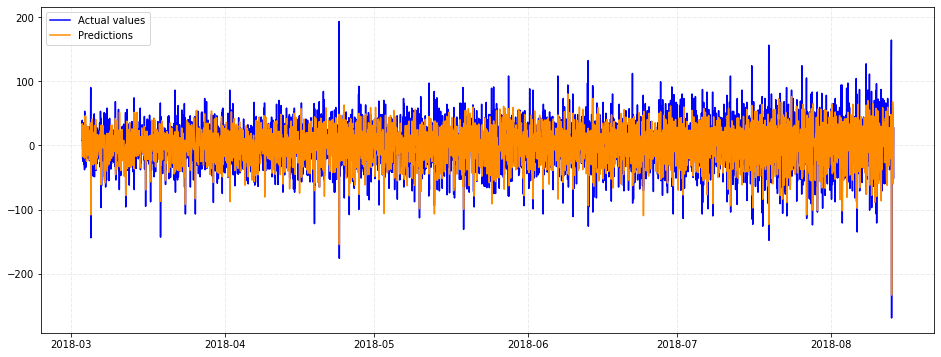

RMSE на обучающей выборке Linear Regression: 23.3860


In [17]:
d = make_features(data_diff, best_lag, best_rolling_mean)

train, test = train_test_split(d, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]

X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_train)

plt.plot(X_train.index, y_train, label='Actual values', color='b')
plt.plot(X_train.index, pred, label='Predictions', color='darkorange')
plt.legend()
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.3)
plt.show()

print("RMSE на обучающей выборке Linear Regression: {:.4f}".format(mean_squared_error(y_train, pred)**0.5))

**CatBoost**

In [18]:
df = make_features(data_diff, best_lag, best_rolling_mean)

In [19]:
train_cat, test_cat = train_test_split(df, shuffle=False, test_size=0.1)
train_cat.dropna(inplace=True)

X_train_cat = train_cat.drop("num_orders", axis=1)
y_train_cat = train_cat["num_orders"]

X_test_cat = test_cat.drop("num_orders", axis=1)
y_test_cat = test_cat["num_orders"]

In [20]:
tscv = TimeSeriesSplit(n_splits=3, test_size=700)
params_cat = {
              "depth" : [i for i in range(10, 21, 5)]
             }

# model = CatBoostRegressor(iterations=300, verbose=100)
# cat = GridSearchCV(estimator=model, param_grid=params_cat, cv=tscv, n_jobs=-1)
# cat.fit(X_train_cat, y_train_cat)
# pred_train = cat.best_estimator_.predict(X_train_cat)

cat = CatBoostRegressor(iterations=300, depth=10, verbose=100)
cat.fit(X_train_cat, y_train_cat)
pred_train = cat.predict(X_train_cat) 

Learning rate set to 0.135208
0:	learn: 34.7235402	total: 76.7ms	remaining: 22.9s
100:	learn: 10.7797124	total: 1.93s	remaining: 3.81s
200:	learn: 5.4838470	total: 3.79s	remaining: 1.87s
299:	learn: 2.8176667	total: 5.64s	remaining: 0us


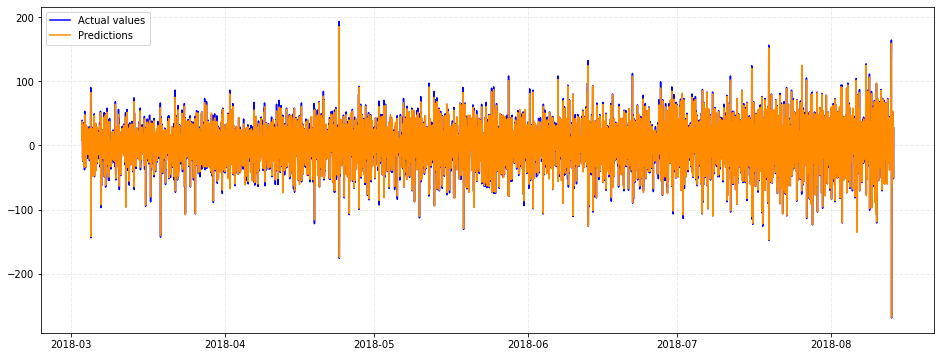

RMSE на обучающей выборке CatBoost: 2.8177


In [21]:
plt.plot(X_train_cat.index, y_train_cat, label='Actual values', color='b')
plt.plot(X_train_cat.index, pred_train, label='Predictions', color='darkorange')
plt.legend()
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.3)
plt.show()

print('RMSE на обучающей выборке CatBoost: {:.4f}'.format(mean_squared_error(y_train_cat, pred_train)**(.5)))

**LightGBM**

In [22]:
params_lgbm = {
               "max_depth" : [i for i in range(10, 25, 5)]
              }
lgbm = LGBMRegressor(random_state=123,n_jobs=-1)
lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, cv=tscv, n_jobs=-1)
lgbm.fit(X_train_cat, y_train_cat)
pred_train_lgbm = lgbm.predict(X_train_cat)

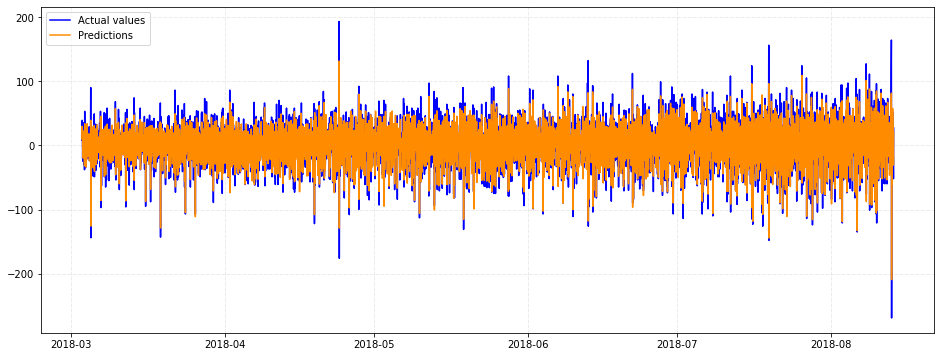

RMSE на обучающей выборке LightGBM: 11.3412


In [23]:
plt.plot(X_train_cat.index, y_train_cat, label='Actual values', color='b')
plt.plot(X_train_cat.index, pred_train_lgbm, label='Predictions', color='darkorange')
plt.legend()
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.3)
plt.show()

print("RMSE на обучающей выборке LightGBM: {:.4f}".format(mean_squared_error(y_train_cat, pred_train_lgbm)**(.5)))

<a id = 'step4'></a>
# Шаг 4. Тестирование

In [24]:
#подготовим данные, чтобы можно было вернуться обратно к исходному ряду

train, test = train_test_split(data, shuffle=False, test_size=0.1) #исходные обучающая и тестовая выборки

test_slice = test[:len(test)-1] #значения, к которым будем прибавлять предсказанную разницу data_diff, 
#тем самым получая следующее значение в исходном временном ряду

t = test[1:len(test)]# выборка для построения графика предсказания и истинных значений

**Linear Regression**

In [25]:
prediction = lin_reg.predict(X_test)

In [26]:
predict = prediction[1:len(prediction)]
predict = pd.DataFrame(predict)


In [27]:
#возвращаемся к исходному ряду
convert = pd.DataFrame(test_slice.values + predict.values, index = t.index)

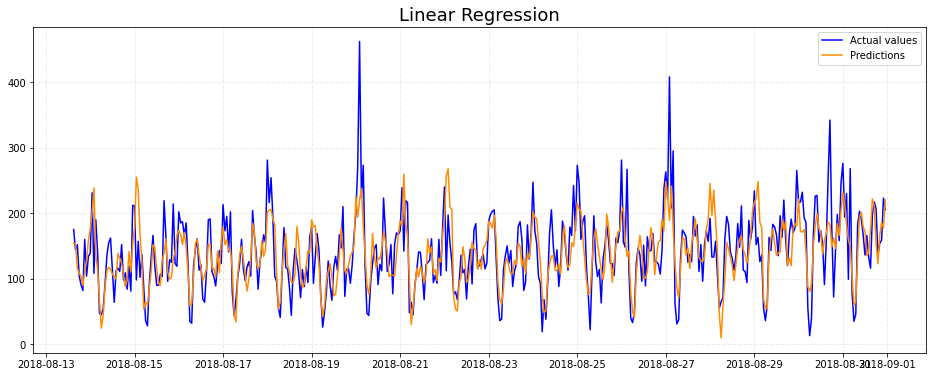

RMSE на тестовой выборке: 41.78


In [28]:
plt.plot(t.index, t.values, label='Actual values', color='b')
plt.plot(convert.index, convert.values, label='Predictions', color='darkorange')
plt.legend()
plt.title('Linear Regression', fontsize=18)
plt.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()
print("RMSE на тестовой выборке: {:.2f}".format(mean_squared_error(y_test, prediction)**0.5))

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=t.index,y=t.values.reshape(-1),name='Actual values'))
fig.add_trace(go.Scatter(x=t.index,y=convert.values.reshape(-1), name='Predictions'))
fig.update_layout(
    title_text='Linear Regression', 
    xaxis_title_text='Time', 
    yaxis_title_text='Calls count', 
    #bargap=0, 
    #bargroupgap=0.1 
)

fig.show()

**CatBoost**

In [30]:
cat_pred = cat.predict(X_test_cat)

In [31]:
predict = cat_pred[1:len(cat_pred)]
predict = pd.DataFrame(predict)

In [32]:
convert = pd.DataFrame(test_slice.values + predict.values, index = t.index)

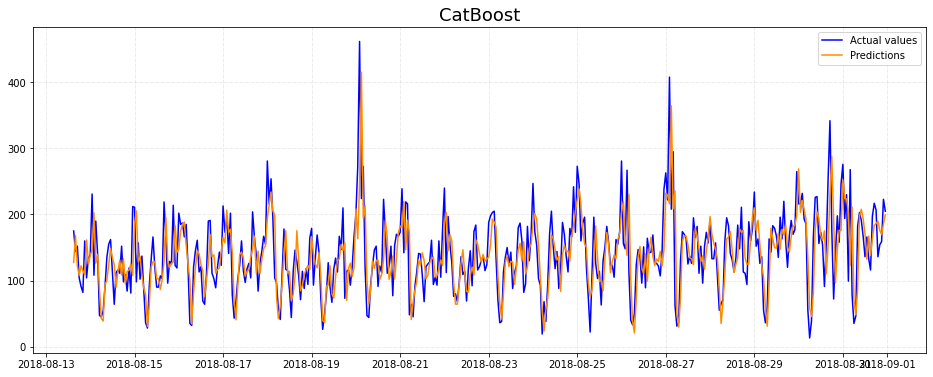

RMSE на тестовой выборке CatBoost: 45.4549


In [33]:
plt.plot(t.index, t.values, label='Actual values', color='b')
plt.plot(convert.index, convert.values, label='Predictions', color='darkorange')
plt.legend()
plt.title('CatBoost', fontsize=18)
plt.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()
print("RMSE на тестовой выборке CatBoost: {:.4f}".format(mean_squared_error(y_test_cat, cat_pred)**(.5)))

**LightGBM**

In [34]:
lgbm_pred = lgbm.predict(X_test_cat)

In [35]:
predict = lgbm_pred[1:len(lgbm_pred)]
predict = pd.DataFrame(predict)

In [36]:
convert = pd.DataFrame(test_slice.values + predict.values, index = t.index)

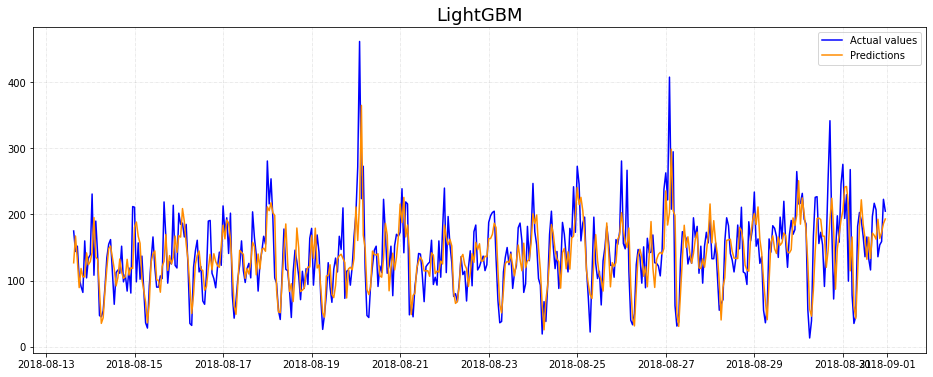

RMSE на тестовой выборке CatBoost: 43.3262


In [37]:
plt.plot(t.index, t.values, label='Actual values', color='b')
plt.plot(convert.index, convert.values, label='Predictions', color='darkorange')
plt.legend()
plt.title('LightGBM', fontsize=18)
plt.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()
print("RMSE на тестовой выборке CatBoost: {:.4f}".format(mean_squared_error(y_test_cat, lgbm_pred)**(.5)))

In [38]:
#проверка на адекватность

pred_median = np.ones(y_test.shape[0]) * y_train.median()
print("RMSE с константой: {:.2f}".format(mean_squared_error(y_test, pred_median)**0.5))
print()
pred_previous = y_test.shift(fill_value=y_train.iloc[-1])
print("RMSE через предыдущее: {:.2f}".format(mean_squared_error(y_test, pred_previous)**0.5))

RMSE с константой: 58.86

RMSE через предыдущее: 92.98


<a id = 'step3'></a>

    
<h2> Общий вывод <a class="tocSkip"></h2>
    
В данной работе нам были предложены исторические данные о заказах такси в аэропортах с целью предсказания  количества заказов такси на следующий час. 
    
Для этого мы загрузили данные, выполнили их ресемплирование по одному часу и проанализировали их. Временной ряд привели к стационарному виду и работали уже с ним. При обучении модели линейной регрессии мы обнаружили, что минимальное значение метрики RMSE на обучающей выборке достигается с параметрами: 
* максимальный размер отставания - 54 
* ширина окна - 9
    
Тогда на тестовой выборке RMSE принимает значение - 41.78. 

Кроме того, мы построили прогнозирующие модели на базе алгоритмов градиентного бустинга CatBoost и LightGBM. Эти алгоритмы переобучались на обучающей выборке и хуже отрабатывали на тестовой. Хотя RMSE у этих алгоритмов не превышает доупистимого значения (~45.45 и ~43.32), лучше все-таки отработал алгоритм обычной линейной регрессии.  
    
Также мы провели проверку на адекватность модели. Т.к. метрика RMSE и в случае предсказания тестовой выборки константой(median), и в случае, когда новое значение прогнозируется предыдущим значением ряда, больше RMSE подобранных оптимальных моделей, делаем вывод, что все модели проверку на адекватность прошли.
   
</div>  